# Naive Bayes implmentation from scratch

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import math
import os

#we will use sklearn and scipy to track accuracy of custom calculations

from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Bayes class implementation

First we will implement the custom Bayes class that is initialized with the training sets of features and outcomes.
<br>

The following methods are later embedded in the class:
- <b>mean_var_calculate</b> - method to calclulate mean and variance of a given column vector. Returns mean and var
- <b>norm_pdf_multivariate</b> - method to calculate value of normal multivariable pdf of a random vector $\vec{x}$ with mean $\mu$ and standard deviation $\sigma^2$
- <b>calculate_likelihood</b> - method to calculate the likelihood of a certain class given a feature vector. Calls methods <b>mean_var_calculate</b> to calculate $\mu$ and $\sigma^2$ for an appropriate class and <b>norm_pdf_multivariate</b> to calculate likelihood of $\vec{x}$ distributed normally with $\sim \mathcal{N}(\mu,\,\sigma^{2})\$
- <b>get_priors</b> - calculates prior class probabilities and return a dictionary of class labels as a key and corresponding prior probability as a value
- <b>naive_bayes_classifier</b> - method to calculate predictions based on naive Bayes method. The method updates two class attributes - <b><i>probability</i></b> and <b><i>prediction</i></b>. We will update and store probability vector to use it later in probability distribution histogram. We also calculate the evidence and use complete Bayes formula normalized by the evidence as a discriminator function to obtain array of actual probabilities
- <b>plot_prob_hist</b> - plots probability histogram. Since the threshold for classification is set to 0.5, the minimum value in range is 0.5
- <b>calc_confusion_matrix</b> - calculates confusion matrix
- <b>calc_accuracy</b> - calculates accuracy
- <b>calc_error</b> - calculates error
- <b>calc_sens</b> - calculates sensitivity
- <b>calc_spec</b> - calculates specificity

In [2]:
"""
Implementation of Bayes class
Class is initialized with the training set of features and outcomes
For each outcome cathegory class implements method to calculate prior probabilities from from the Train Set
For each outcome cathegory class implements method to calculate likelihood using norm_pdf_multivariate method
Class implements method to calculate naive Bayess predictions for the test data
Class implements method to calculate confusion matrix and metods to calculate classifier performance
"""

class Bayes:
    def __init__(self, X_train, Y_train):
        
        self.X_train = X_train
        self.Y_train = Y_train
        self.probability = []
        self.prediction = []
        
    def mean_var_calculate(self, data):
        
        n_points = data.shape[0]
        n_features = self.X_train.shape[1]
        
        mu = data.sum(axis=0)/n_points
        sigma = np.zeros((n_features, n_features))
        
        x_mu = data - mu.T
        
        for i in range(n_features):
            sigma[i, i] = np.dot(x_mu[:, i].T, x_mu[:, i])
            sigma[i, i] /= n_points
            
        return mu, sigma
    
    """
    Multivariate normal pdf calculation
    Input: x = feature vector
           mu = mean of the data
           sigma = std of the data
    """
    
    def norm_pdf_multivariate(self, x, mu, sigma):
    
        dim = len(x)
        
        det = np.linalg.det(sigma)
        inv = np.linalg.inv(sigma)
        
        norm_const = 1.0/( math.pow((2*math.pi),float(dim)/2) * math.pow(det,1.0/2) )
        x_mu = x - mu
        result = math.pow(math.e, -0.5 * ((np.dot(np.dot(x_mu, inv ), x_mu.T))))
        
        return norm_const * result
    
    """
    Calculate prior probabilites
    Output: dictionary in the format {class, propability}
    """
    def get_priors(self): 
        
        labels, counts = np.unique(self.Y_train, return_counts=True)
        
        output = {}
        
        for i, label in enumerate(labels):
            output[int(label)] = float(counts[i])/len(self.Y_train)
        return output  
    
    """
    Calculate likelihood of feature vector x, given class label
    Input: x = feature vector
           label = output class
    Output: probability x conditioned on label
    """
    
    def calculate_likelihood(self, x, label):
        
        sub_array = np.where(self.Y_train == label)
        mu, sigma = self.mean_var_calculate(self.X_train[sub_array])
        
        likelihood = self.norm_pdf_multivariate(x, mu, sigma)
        return likelihood
    
    """
    Classifier function
    Outputs a vector of class predictions that has the same dimension 
    as a vector of class outcomes in test data
    """
    
    def naive_bayes_classifier(self, X_test):
        
        assert X_test.shape[1] == self.X_train.shape[1], "Number of features doesn't match train set!"
        
        prior = self.get_priors(); 
        possible_labels = list(prior.keys());
        self.prediction = np.zeros(len(X_test))
        self.probability = np.zeros(len(X_test))
            
        for i, x_test_vector in enumerate(X_test):
#            prediction = 0
            evidence = sum(self.calculate_likelihood(x_test_vector, label)*prior[label] \
                                for label in possible_labels)
            for label in possible_labels:
                posterior = self.calculate_likelihood(x_test_vector, label)*prior[label]   \
                            / evidence 
                if posterior > self.probability[i]:
                    self.probability[i] = posterior
                    self.prediction[i] = label
        return self.prediction
    
    """
    Probability histogram plot
    Plots histogram of calculated probability values
    based on the prediction category
    """
    
    def plot_prob_hist(self):
        
        for label in np.unique(self.Y_train):
            idx = np.where(self.prediction == label)
            plt.hist(x=self.probability[idx], bins=math.floor(len(self.probability)/10), 
                     label = "predicted " + str(label), alpha=0.7, rwidth=0.85)        
        
        plt.grid(axis='y', alpha=0.75)
        plt.legend(loc='upper left')
        plt.xlabel('P of prediction'); plt.ylabel('Frequency')
        plt.title('Probability Frequency Plot')
        
    
    def calc_confusion_matrix(self, Y_pred, Y_test): #confusion matrix
       
        assert Y_pred.shape == Y_test.shape, "Vectors of predictions and outcomes should be the same length!"
        
        conf_mtrx = np.empty([2, 2], dtype = int)
        
        TN = Y_pred[(Y_pred == Y_test) & (Y_test == 0)]
        FP = Y_pred[(Y_pred !=Y_test) & (Y_test == 0)]
        FN = Y_pred[(Y_pred != Y_test) & (Y_test == 1)]
        TP = Y_pred[(Y_pred == Y_test) & (Y_test == 1)]
        
        conf_mtrx[0,0] = len(TN); conf_mtrx[0,1] = len(FP)
        conf_mtrx[1,0] = len(FN); conf_mtrx[1,1] = len(TP)
        
        return conf_mtrx
    
    def calc_accuracy(self, Y_pred, Y_test): #Acuracy
        
        conf_mtrx = self.calc_confusion_matrix(Y_pred, Y_test)
        
        return (conf_mtrx[0,0] + conf_mtrx[1,1])/ np.sum(conf_mtrx)
    
    def calc_error(self, Y_pred, Y_test): #Error rate = 1-accuracy
        
        conf_mtrx = self.calc_confusion_matrix(Y_pred, Y_test)
        
        return (conf_mtrx[0,1] + conf_mtrx[1,0])/ np.sum(conf_mtrx)
    
    def calc_sens(self, Y_pred, Y_test): #Sensitivity
        
        conf_mtrx = self.calc_confusion_matrix(Y_pred, Y_test)

        return conf_mtrx[1,1]/(conf_mtrx[1,0] + conf_mtrx[1,1])
    
    def calc_spec(self, Y_pred, Y_test): #Specificity
        
        conf_mtrx = self.calc_confusion_matrix(Y_pred, Y_test)
        
        return conf_mtrx[0,0]/(conf_mtrx[0,0] + conf_mtrx[0,1])

# Testing the classifier

Let's test the custom Bayes classifier. First we will start by defining a helper function to load the data.
<br>
Our helper assumes that first $(n-1)$ columns contain the feature data and the last column contains the outcome.
<br>
It is worth mentioning that our custom Bayes classifier takes the data on the input in the format described above. The project data is already presented in a such a way. Otherwise, consider additional preprocessing of the data before passing it to the Bayes object

In [3]:
if __name__ == "__main__":

    #Define a helper function to load the data
    def data_loader(path): 

        data = pd.read_csv(path, header=None, engine='python').values
 #       data = data.drop(3, axis = 1)
        feature = data[:, :-1]
        outcome = data[:, -1]
        
        return feature, outcome

# Basic set statistics
Let's load full data set first and look at some set statistics.
We can see from the data statistics that mean values for class '1' (diabetes) are higher than mean values for class '0' (non-diabetes). However, the standard deviations for class '1' are also higher, which implies bigger spread distribution of the data and could possibly affect correct prediction of class '1'.

In [4]:
path = os.getcwd()

df = pd.read_csv(os.path.join(path, "data/pima-indians-diabetes.data.csv"), header=None, engine='python').values
df = pd.DataFrame(df, index=[i for i in range(df.shape[0])], 
                  columns=['f'+str(i+1) for i in range(df.shape[1])])

from IPython.display import display, Markdown

display(Markdown("# Data statistics for outcome category '1'"))
display(df.where(df["f9"]==1).describe())
display(Markdown("# Data statistics for outcome category '0'"))
display(df.where(df["f9"]==0).describe())

# Data statistics for outcome category '1'

,f1,f2,f3,f4,f5,f6,f7,f8,f9
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.0
mean,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164,1.0
std,3.741239,31.939622,21.491812,17.679711,138.689125,7.262967,0.372354,10.968254,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.088000,21.000000,1.0
25%,1.750000,119.000000,66.000000,0.000000,0.000000,30.800000,0.262500,28.000000,1.0
50%,4.000000,140.000000,74.000000,27.000000,0.000000,34.250000,0.449000,36.000000,1.0
75%,8.000000,167.000000,82.000000,36.000000,167.250000,38.775000,0.728000,44.000000,1.0
max,17.000000,199.000000,114.000000,99.000000,846.000000,67.100000,2.420000,70.000000,1.0


# Data statistics for outcome category '0'

,f1,f2,f3,f4,f5,f6,f7,f8,f9
count,500.000000,500.0000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.0
mean,3.298000,109.9800,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000,0.0
std,3.017185,26.1412,18.063075,14.889947,98.865289,7.689855,0.299085,11.667655,0.0
min,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.0
25%,1.000000,93.0000,62.000000,0.000000,0.000000,25.400000,0.229750,23.000000,0.0
50%,2.000000,107.0000,70.000000,21.000000,39.000000,30.050000,0.336000,27.000000,0.0
75%,5.000000,125.0000,78.000000,31.000000,105.000000,35.300000,0.561750,37.000000,0.0
max,13.000000,197.0000,122.000000,60.000000,744.000000,57.300000,2.329000,81.000000,0.0


Now we will load the data into <i>train</i> and <i>test</i> sets

> <b>Note</b>: In order for this section of code to run correctly create /data folder in the notebook directory and save train.csv and test.csv files inside the directory

In [5]:
X_train, Y_train = data_loader(os.path.join(path, "data/train.csv"))
X_test, Y_test = data_loader(os.path.join(path, "data/test.csv"))



# Making custom predictions
We now will make predictions using our custom built classifier and calculate confusion matrix of the results

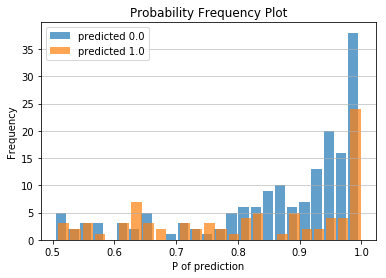

In [6]:
custom = Bayes(X_train, Y_train) #create custom Bayes classifier
clf_predict=custom.naive_bayes_classifier(X_test) #predict values
conf = custom.calc_confusion_matrix(clf_predict, Y_test) #calculate confusion matix
custom.plot_prob_hist()

As we can see from probability histogram plot, majority of predictions are made based on high class probabilities greater than 90%. Moreover, we can see from the plot that roughly 100 predictions out of 254 are made with probability of >94%.

<br>
Now let's display the performance numbers and examine the results

In [7]:
print("Prediction using custom Bayes classifier:\n")
print('Custom confusion matrix:\n', conf)
print('\nAccuracy score (ability rate of correctly classifying cases in general): ', custom.calc_accuracy(clf_predict, Y_test))
print('Error score: (failure rate of correctly classifying cases in general)', custom.calc_error(clf_predict, Y_test))
print('Sensitivity score (ability rate of correctly classifying cases with the disease): ', custom.calc_sens(clf_predict, Y_test))
print('Specificity score: (ability rate of correctly classifying cases without the disease)', custom.calc_spec(clf_predict, Y_test))

Prediction using custom Bayes classifier:

Custom confusion matrix:
 [[132  28]
 [ 36  58]]

Accuracy score (ability rate of correctly classifying cases in general):  0.7480314960629921
Error score: (failure rate of correctly classifying cases in general) 0.25196850393700787
Sensitivity score (ability rate of correctly classifying cases with the disease):  0.6170212765957447
Specificity score: (ability rate of correctly classifying cases without the disease) 0.825


Overall our classifier achieved the accuracy score of ~75%
<br>
However, with this type of model we were able to achieve sensitivity score of only ~62%. In a task of identifying patients with diabetes conditions, we would probably want to achieve higher sensitivity score.

# Validating results

To make sure that our custom classifier works correctly we compared our classification to classification that we obtained using scikit-learn Python library. The following results exactly matched our custom classification

In [8]:
classifier = GaussianNB()
classifier.fit(X_train, Y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)

print('Scikit-learn confusion matrix:\n', cm)
print('Accuracy score scikit-learn: ', accuracy_score(Y_test, y_pred))

Scikit-learn confusion matrix:
 [[132  28]
 [ 36  58]]
Accuracy score scikit-learn:  0.7480314960629921


# Finding the best and the worst accuracy
Now let's create a helper function that will randomly split data into test and validation sets and run our classifier 100 times and register best, worst and average accuracy. It is worth mentioning that initially we reserved 70% of data to the training set and got ~75% average accuracy

In [9]:
import random

def split_function(data_x, data_y, ratio = 0.70):
    
    assert data_x.shape[0] == data_y.shape[0]
    
    train_idx = random.sample(range(data_x.shape[0]), math.floor(ratio*data_x.shape[0]));
    test_idx = np.array([i for i in range(data_x.shape[0]) if i not in train_idx]);
    return data_x[train_idx] , data_y[train_idx], data_x[test_idx], data_y[test_idx]
    

We will evaluate average classifier accuracy using 25% of the data as a training set, specifically, 192 data points. The obtained results show less than 1% average accuracy decrease going from 70% down to 25% of the training data size. Therefore, by the nature of the classifier, we can conclude that data doesn't have outliers and and well distributed. 

In [10]:
data_x, data_y = data_loader(os.path.join(path, "data/pima-indians-diabetes.data.csv"))

acc = [] #list of all accuracies

for N in range (100):
    X_train, Y_train, X_test, Y_test = split_function(data_x, data_y, ratio = 0.25)
    custom = Bayes(X_train, Y_train) #create custom Bayes classifier
    clf_predict=custom.naive_bayes_classifier(X_test) #predict values
    acc.append(custom.calc_accuracy(clf_predict, Y_test)) #append to accuracy array

In [11]:
print('Best accuracy: ', np.max(acc))
print('Worst accuracy: ', np.min(acc))
print('Average accuracy: ', np.mean(acc))

Best accuracy:  0.78125
Worst accuracy:  0.6927083333333334
Average accuracy:  0.7432986111111112
